# CNN on CIFAR-10 Dataset.
## 1.1 Loading dataset

In [36]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.4.0+cu121
torchvision version: 0.19.0+cu121


In [37]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 32, 32])
Label: 6


In [39]:
class_names = train_data.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 1.2 Visualise data


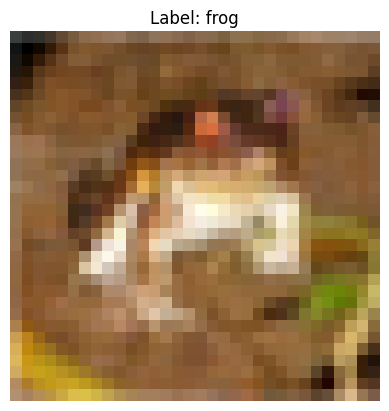

In [40]:
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {class_names[label]}")
plt.axis(False)
plt.show()


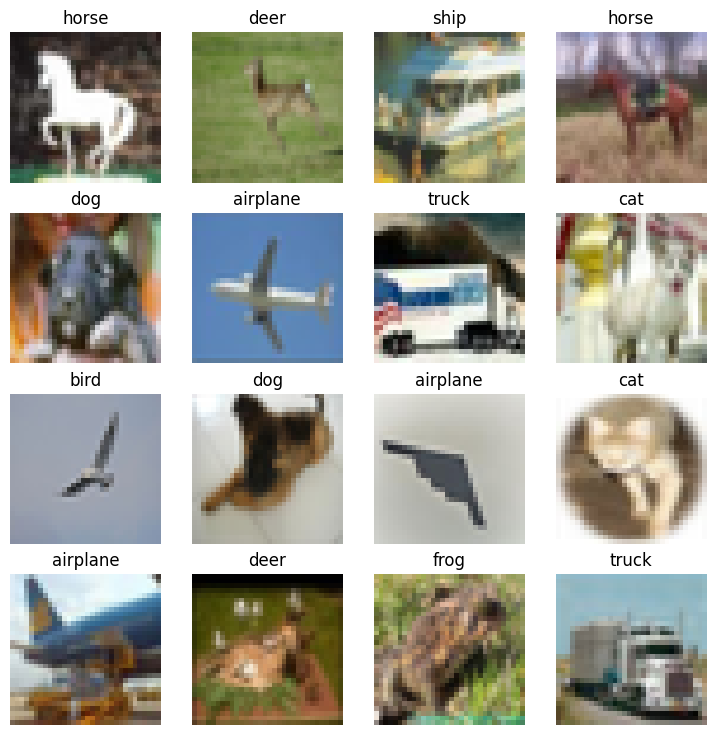

In [41]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False);

## 2.1 Preparing Dataloader.

In [42]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Length of  train dataloader: {len(train_dataloader)} batches of 32")
print(f"Length of  test dataloader: {len(test_dataloader)} batches of 32")

Length of  train dataloader: 1563 batches of 32
Length of  test dataloader: 313 batches of 32


## 2.2 Preparing baseline model.

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [44]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, len(class_names)),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model_0 = NeuralNetwork().to(device)
model_0


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [45]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize the optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model_0.parameters(), lr=learning_rate)

In [46]:
def train_loop(dataloader, model, loss_fn, optimizer, device = device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Send to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * 32 + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device = device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [47]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_0, loss_fn, optimizer)
    test_loop(test_dataloader, model_0, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303795  [   32/50000]
loss: 2.087607  [ 3232/50000]
loss: 1.969432  [ 6432/50000]
loss: 1.848646  [ 9632/50000]
loss: 2.339229  [12832/50000]
loss: 1.746883  [16032/50000]
loss: 1.841221  [19232/50000]
loss: 1.759842  [22432/50000]
loss: 1.742650  [25632/50000]
loss: 2.023501  [28832/50000]
loss: 1.942709  [32032/50000]
loss: 1.815819  [35232/50000]
loss: 1.966051  [38432/50000]
loss: 1.993686  [41632/50000]
loss: 1.752297  [44832/50000]
loss: 1.867573  [48032/50000]
Test Error: 
 Accuracy: 35.5%, Avg loss: 1.811119 

Epoch 2
-------------------------------
loss: 1.504079  [   32/50000]
loss: 1.845032  [ 3232/50000]
loss: 1.825686  [ 6432/50000]
loss: 1.503426  [ 9632/50000]
loss: 1.831388  [12832/50000]
loss: 1.699176  [16032/50000]
loss: 1.701208  [19232/50000]
loss: 1.690387  [22432/50000]
loss: 1.415644  [25632/50000]
loss: 1.781639  [28832/50000]
loss: 1.778555  [32032/50000]
loss: 1.677190  [35232/50000]
loss: 1.768976  [38432/50000

In [48]:
def eval_model(dataloader, model, loss_fn, device = device):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
      for X, y in dataloader:
          X, y = X.to(device), y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  return  {
      "model_name": model.__class__.__name__, # only works when model was created with a class
      "model_loss": test_loss,
      "model_acc": (100*correct)
  }

In [49]:
model_0_results = eval_model(test_dataloader, model_0, loss_fn)
model_0_results

{'model_name': 'NeuralNetwork',
 'model_loss': 1.539938941550331,
 'model_acc': 45.51}

## 3.1 Changing model to a convolutional network. (TinyVGG)

In [65]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*8*8, out_features=output_shape)
    )

  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_1

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=10, bias=True)
  )
)

In [66]:
# Initialize optimizer.
learning_rate = 0.1
optimizer = torch.optim.SGD(model_1.parameters(), lr=learning_rate)

In [67]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_1, loss_fn, optimizer)
    test_loop(test_dataloader, model_1, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300085  [   32/50000]
loss: 2.315339  [ 3232/50000]
loss: 2.295742  [ 6432/50000]
loss: 2.300848  [ 9632/50000]
loss: 2.302663  [12832/50000]
loss: 2.253681  [16032/50000]
loss: 2.287767  [19232/50000]
loss: 2.263502  [22432/50000]
loss: 1.995803  [25632/50000]
loss: 2.108276  [28832/50000]
loss: 2.026517  [32032/50000]
loss: 2.065445  [35232/50000]
loss: 1.817062  [38432/50000]
loss: 1.576854  [41632/50000]
loss: 1.665845  [44832/50000]
loss: 1.516781  [48032/50000]
Test Error: 
 Accuracy: 40.9%, Avg loss: 1.683973 

Epoch 2
-------------------------------
loss: 1.706599  [   32/50000]
loss: 1.946531  [ 3232/50000]
loss: 1.566679  [ 6432/50000]
loss: 1.761569  [ 9632/50000]
loss: 1.468399  [12832/50000]
loss: 1.650820  [16032/50000]
loss: 1.738976  [19232/50000]
loss: 1.245012  [22432/50000]
loss: 1.918975  [25632/50000]
loss: 1.305920  [28832/50000]
loss: 1.413493  [32032/50000]
loss: 1.639222  [35232/50000]
loss: 1.354127  [38432/50000

In [68]:
model_1_results = eval_model(test_dataloader, model_1, loss_fn)
model_1_results

{'model_name': 'TinyVGG',
 'model_loss': 1.2142895315401852,
 'model_acc': 57.60999999999999}

## 3.2 Fine tuning hyper-parameters of TinyVGG to improve model.

In [69]:
class MyCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*8*8, out_features=hidden_units*8*8),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units*8*8, out_features=output_shape)
    )

  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

my_model = MyCNN(input_shape=3, hidden_units=64, output_shape=len(class_names)).to(device)
my_model

MyCNN(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): ReLU()
    (3): Linear(in_features=4096, out_features=10, bias=True)
  )
)

In [70]:
# Initialize optimizer.
learning_rate = 0.1
optimizer = torch.optim.SGD(my_model.parameters(), lr=learning_rate)

In [71]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, my_model, loss_fn, optimizer)
    test_loop(test_dataloader, my_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302961  [   32/50000]
loss: 2.211118  [ 3232/50000]
loss: 2.260304  [ 6432/50000]
loss: 2.369805  [ 9632/50000]
loss: 2.073658  [12832/50000]
loss: 1.814906  [16032/50000]
loss: 2.015254  [19232/50000]
loss: 1.935227  [22432/50000]
loss: 1.711994  [25632/50000]
loss: 1.758090  [28832/50000]
loss: 1.367390  [32032/50000]
loss: 1.753028  [35232/50000]
loss: 1.502707  [38432/50000]
loss: 1.676265  [41632/50000]
loss: 1.854739  [44832/50000]
loss: 1.817542  [48032/50000]
Test Error: 
 Accuracy: 45.6%, Avg loss: 1.488759 

Epoch 2
-------------------------------
loss: 1.493003  [   32/50000]
loss: 0.999579  [ 3232/50000]
loss: 1.275282  [ 6432/50000]
loss: 1.254751  [ 9632/50000]
loss: 1.440005  [12832/50000]
loss: 0.888380  [16032/50000]
loss: 1.425171  [19232/50000]
loss: 1.805051  [22432/50000]
loss: 0.981449  [25632/50000]
loss: 1.027290  [28832/50000]
loss: 1.312875  [32032/50000]
loss: 1.266499  [35232/50000]
loss: 1.103691  [38432/50000

In [72]:
my_model_results = eval_model(test_dataloader, my_model, loss_fn)
my_model_results

{'model_name': 'MyCNN', 'model_loss': 1.1976589221543017, 'model_acc': 65.14}

In [73]:
## Creating a new model without adding a second linear layer to see the difference.
class MyCNN2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*8*8, out_features=output_shape)
    )

  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

my_model2 = MyCNN2(input_shape=3, hidden_units=64, output_shape=len(class_names)).to(device)
my_model2

MyCNN2(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=10, bias=True)
  )
)

In [74]:
# Initialize optimizer
optimizer = torch.optim.SGD(my_model2.parameters(), lr=learning_rate)

In [75]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, my_model2, loss_fn, optimizer)
    test_loop(test_dataloader, my_model2, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303205  [   32/50000]
loss: 2.186621  [ 3232/50000]
loss: 2.303086  [ 6432/50000]
loss: 2.061975  [ 9632/50000]
loss: 2.247755  [12832/50000]
loss: 2.024281  [16032/50000]
loss: 2.058762  [19232/50000]
loss: 2.045382  [22432/50000]
loss: 1.894694  [25632/50000]
loss: 1.547410  [28832/50000]
loss: 1.527331  [32032/50000]
loss: 1.489804  [35232/50000]
loss: 1.454204  [38432/50000]
loss: 1.560458  [41632/50000]
loss: 1.441270  [44832/50000]
loss: 1.278957  [48032/50000]
Test Error: 
 Accuracy: 49.3%, Avg loss: 1.433624 

Epoch 2
-------------------------------
loss: 1.394037  [   32/50000]
loss: 1.229475  [ 3232/50000]
loss: 1.621571  [ 6432/50000]
loss: 1.158024  [ 9632/50000]
loss: 1.482118  [12832/50000]
loss: 1.254775  [16032/50000]
loss: 0.955241  [19232/50000]
loss: 1.091107  [22432/50000]
loss: 0.929904  [25632/50000]
loss: 1.032432  [28832/50000]
loss: 0.935829  [32032/50000]
loss: 1.237491  [35232/50000]
loss: 0.952011  [38432/50000

In [76]:
my_model2_results = eval_model(test_dataloader, my_model2, loss_fn)
my_model2_results

{'model_name': 'MyCNN2', 'model_loss': 0.831192167231831, 'model_acc': 71.5}

### 4.1 Compare model results.

In [77]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, my_model_results, my_model2_results])
compare_results

,model_name,model_loss,model_acc
0,NeuralNetwork,1.539939,45.51
1,TinyVGG,1.214290,57.61
2,MyCNN,1.197659,65.14
3,MyCNN2,0.831192,71.50


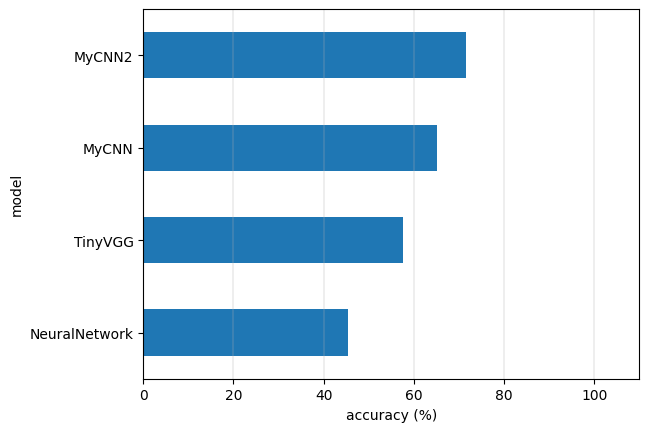

In [90]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")
plt.xlim([0,110])
plt.grid(True, axis = 'x', lw = 0.3)

### 5.1 Conclusion

Learned how to train, test and evaluate my own CNN model and aswell as fiddling with parameters and to create my own versions. Interesting find is that for convolutional neural networks of this size a double linear layer at the end seems to be over-fitting the data. My hypothesis is that our max pool is too intense leaving too little of data to extract patterns, hence the over-fitting, therefore to prove or disprove the hypothesis I would see how it would perform with less pooling layers, or some sort of other structures that extracts features in a greater dimension than 8x8 or maybe it would work on higher definition images overall and double linear layers just don't work on such small images.